# Assignment #3: Dimensionality Reduction Methods

**Using the "modified_dataset.csv" produced in Assignment #1**

---

## Overview

This assignment consists of three parts:

1. **PCA Method with Mean-Filling**  
2. **PCA Method with Maximum Likelihood Estimation (MLE)**  
3. **Singular Value Decomposition (SVD)**

---


Total number of users (Tnu): 50
Total number of items (Tni): 138

Number of ratings for each item:
 write         49
adulthood     49
journey       49
simile        49
growing-up    49
              ..
yourself      41
music         40
women         40
literature    40
abilities     40
Length: 138, dtype: int64


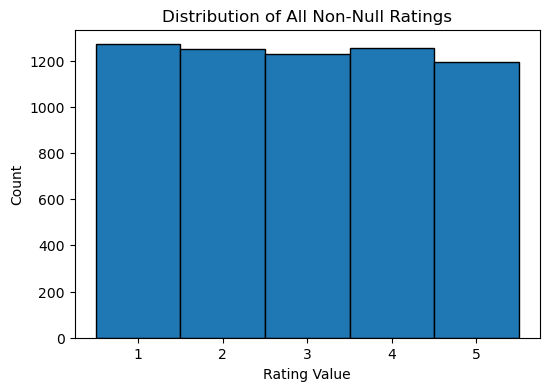

Matrix Sparsity: 10.22%
Average rating across entire matrix: 2.975

Target items chosen (lowest rated): I1=aliteracy, I2=understanding

[Part 1] Step 3.2.1: I1=aliteracy Mean=2.4667, I2=understanding Mean=2.4889

[Part 1] Covariance matrix shape: (138, 138)

[Part 1] Top-5 peers for aliteracy: ['faith', 'attributed', 'philosophy', 'difficult', 'travel']
[Part 1] Top-10 peers for aliteracy: ['faith', 'attributed', 'philosophy', 'difficult', 'travel', 'inspirational', 'learning', 'attributed-no-source', 'girls', 'dreams']
[Part 1] Top-5 peers for understanding: ['activism', 'misattributed-to-mother-teresa', 'edison', 'opposite', 'fate']
[Part 1] Top-10 peers for understanding: ['activism', 'misattributed-to-mother-teresa', 'edison', 'opposite', 'fate', 'lies', 'misattributed-mark-twain', 'miracles', 'books', 'fairy-tales']

[Part 1] Predicted missing ratings for aliteracy with top-5 peers:
User 13 -> 2.200
User 16 -> 2.250
User 19 -> 3.200
User 24 -> 4.400
User 44 -> 3.400

[Part 1] Pred

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------
# PART 1: PCA with Mean-Filling
#  (Sections 3.1, 3.2 in the assignment)
# -----------------------------------------------------------------

# 1. Load the dataset ("modified_dataset.csv") from Assignment #1 (or #2)
df = pd.read_csv("modified_dataset.csv")

# The dataset has 3 text columns: Quote, Author, Tags
# Everything else from column index 3 onward are rating columns.
rating_cols = df.columns[3:]
rating_matrix = df[rating_cols].copy()  # NxM matrix (N=users, M=items)

# -----------------------------------------------------------------
# 3.1.1, 3.1.2: The dataset is already on a 1-to-5 scale.
# Count total number of users (Tnu), total number of items (Tni)
# -----------------------------------------------------------------
Tnu = rating_matrix.shape[0]
Tni = rating_matrix.shape[1]

print("Total number of users (Tnu):", Tnu)
print("Total number of items (Tni):", Tni)

# -----------------------------------------------------------------
# 3.1.5: Count number of ratings for every item
# -----------------------------------------------------------------
rating_counts = rating_matrix.notnull().sum().sort_values(ascending=False)
print("\nNumber of ratings for each item:\n", rating_counts)

# -----------------------------------------------------------------
# 3.1.6: Draw the distribution of ratings & assess sparsity
# -----------------------------------------------------------------
all_ratings_series = rating_matrix.values.flatten()
all_ratings_series = all_ratings_series[~pd.isnull(all_ratings_series)]  # drop NaN

plt.figure(figsize=(6,4))
plt.hist(all_ratings_series, bins=[1,2,3,4,5,6], edgecolor='black', align='left')
plt.title("Distribution of All Non-Null Ratings")
plt.xlabel("Rating Value")
plt.ylabel("Count")
plt.xticks([1,2,3,4,5])
plt.show()

# Assess matrix sparsity
total_possible = Tnu * Tni
non_null_count = rating_matrix.notnull().sum().sum()
sparsity = 1 - (non_null_count / total_possible)
print(f"Matrix Sparsity: {sparsity*100:.2f}%")

# Quick check for potential rating bias
avg_rating = np.nanmean(rating_matrix.values)
print(f"Average rating across entire matrix: {avg_rating:.3f}")

# -----------------------------------------------------------------
# 3.1.7: Choose the two lowest rated items (I1, I2)
#         using average rating across each item
# -----------------------------------------------------------------
item_means = rating_matrix.mean(axis=0)
lowest_rated_items = item_means.sort_values().index[:2]
I1, I2 = lowest_rated_items[0], lowest_rated_items[1]
print(f"\nTarget items chosen (lowest rated): I1={I1}, I2={I2}")

# -----------------------------------------------------------------
# 3.2.1: Calculate average rating for I1 and I2
# -----------------------------------------------------------------
I1_mean = rating_matrix[I1].mean(skipna=True)
I2_mean = rating_matrix[I2].mean(skipna=True)
print(f"\n[Part 1] Step 3.2.1: I1={I1} Mean={I1_mean:.4f}, I2={I2} Mean={I2_mean:.4f}")

# -----------------------------------------------------------------
# 3.2.2: Replace missing ratings of I1 and I2 with their corresponding mean
# -----------------------------------------------------------------
pca_meanfill_data = rating_matrix.copy()
pca_meanfill_data[I1] = pca_meanfill_data[I1].fillna(I1_mean)
pca_meanfill_data[I2] = pca_meanfill_data[I2].fillna(I2_mean)

# -----------------------------------------------------------------
# 3.2.3: Calculate the average rating for each item (entire matrix)
# -----------------------------------------------------------------
item_mean_all = pca_meanfill_data.mean(axis=0)

# -----------------------------------------------------------------
# 3.2.4: For each item, calculate the difference between ratings and the mean
# -----------------------------------------------------------------
diff_matrix = pca_meanfill_data - item_mean_all

# -----------------------------------------------------------------
# 3.2.5 & 3.2.6: Compute pairwise covariance and generate covariance matrix
# -----------------------------------------------------------------
cov_matrix = diff_matrix.cov()  # item–item covariance
print("\n[Part 1] Covariance matrix shape:", cov_matrix.shape)

# -----------------------------------------------------------------
# 3.2.7: Determine the top-5 peers and top-10 peers for I1 and I2
# -----------------------------------------------------------------
def get_top_peers(cov_mat, item, top_k=5):
    sorted_items = cov_mat[item].abs().sort_values(ascending=False)
    top_peers = sorted_items.iloc[1:top_k+1].index.tolist()  # skip itself
    return top_peers

I1_top5 = get_top_peers(cov_matrix, I1, 5)
I1_top10 = get_top_peers(cov_matrix, I1, 10)
I2_top5  = get_top_peers(cov_matrix, I2, 5)
I2_top10 = get_top_peers(cov_matrix, I2, 10)

print(f"\n[Part 1] Top-5 peers for {I1}: {I1_top5}")
print(f"[Part 1] Top-10 peers for {I1}: {I1_top10}")
print(f"[Part 1] Top-5 peers for {I2}: {I2_top5}")
print(f"[Part 1] Top-10 peers for {I2}: {I2_top10}")

# -----------------------------------------------------------------
# 3.2.8: Determine reduced dimensional space for each user
#        in case of using the top-5 peers for each target item
# -----------------------------------------------------------------
def reduce_dimensional_space(data, target_item, top_peers_list):
    selected_cols = [target_item] + top_peers_list
    reduced_data = data[selected_cols].copy()
    return reduced_data

I1_reduced5 = reduce_dimensional_space(pca_meanfill_data, I1, I1_top5)
I2_reduced5 = reduce_dimensional_space(pca_meanfill_data, I2, I2_top5)

# -----------------------------------------------------------------
# 3.2.9: Predict missing ratings of I1, I2 (original missing)
#        using top-5 peers (simple average approach)
# -----------------------------------------------------------------
def predict_with_peers(reduced_data, full_data, target_item, original_missing_mask):
    predictions = {}
    peers_cols = [c for c in reduced_data.columns if c != target_item]
    for user_idx in full_data.index:
        if original_missing_mask[user_idx]:  # user had missing rating originally
            row_peers = reduced_data.loc[user_idx, peers_cols]
            if row_peers.notna().sum() == 0:
                predictions[user_idx] = np.nan
            else:
                predictions[user_idx] = row_peers.mean(skipna=True)
    return predictions

# Identify which users originally had missing for I1 or I2
original_missing_I1 = rating_matrix[I1].isnull()
original_missing_I2 = rating_matrix[I2].isnull()

# Predict with top-5
pred_I1_top5 = predict_with_peers(I1_reduced5, rating_matrix, I1, original_missing_I1)
pred_I2_top5 = predict_with_peers(I2_reduced5, rating_matrix, I2, original_missing_I2)

print(f"\n[Part 1] Predicted missing ratings for {I1} with top-5 peers:")
for k, v in pred_I1_top5.items():
    print(f"User {k} -> {v:.3f}")

print(f"\n[Part 1] Predicted missing ratings for {I2} with top-5 peers:")
for k, v in pred_I2_top5.items():
    print(f"User {k} -> {v:.3f}")

# -----------------------------------------------------------------
# 3.2.10 & 3.2.11: Repeat for top-10 peers
# -----------------------------------------------------------------
I1_reduced10 = reduce_dimensional_space(pca_meanfill_data, I1, I1_top10)
I2_reduced10 = reduce_dimensional_space(pca_meanfill_data, I2, I2_top10)

pred_I1_top10 = predict_with_peers(I1_reduced10, rating_matrix, I1, original_missing_I1)
pred_I2_top10 = predict_with_peers(I2_reduced10, rating_matrix, I2, original_missing_I2)

print(f"\n[Part 1] Predicted missing ratings for {I1} with top-10 peers:")
for k, v in pred_I1_top10.items():
    print(f"User {k} -> {v:.3f}")

print(f"\n[Part 1] Predicted missing ratings for {I2} with top-10 peers:")
for k, v in pred_I2_top10.items():
    print(f"User {k} -> {v:.3f}")

# -----------------------------------------------------------------
# 3.2.12: Compare the results of point 3.2.9 (top-5) with
#         results of point 3.2.11 (top-10) for I1 and I2
# -----------------------------------------------------------------
print("\n[Part 1] 3.2.12: Compare top-5 vs. top-10 predictions (I1 and I2).")

# Compare I1 predictions
print("\n--- Comparison of top-5 vs. top-10 for I1 ---")
for user in sorted(pred_I1_top5.keys()):  # users who had missing for I1
    val5 = pred_I1_top5[user]
    val10 = pred_I1_top10[user]
    if val5 is not None and not np.isnan(val5) and val10 is not None and not np.isnan(val10):
        diff = val10 - val5
        print(f"User {user}: top-5 = {val5:.3f}, top-10 = {val10:.3f}, diff = {diff:.3f}")
    else:
        print(f"User {user}: top-5 = {val5}, top-10 = {val10}, diff = N/A")

# Compare I2 predictions
print("\n--- Comparison of top-5 vs. top-10 for I2 ---")
for user in sorted(pred_I2_top5.keys()):  # users who had missing for I2
    val5 = pred_I2_top5[user]
    val10 = pred_I2_top10[user]
    if val5 is not None and not np.isnan(val5) and val10 is not None and not np.isnan(val10):
        diff = val10 - val5
        print(f"User {user}: top-5 = {val5:.3f}, top-10 = {val10:.3f}, diff = {diff:.3f}")
    else:
        print(f"User {user}: top-5 = {val5}, top-10 = {val10}, diff = N/A")

print("""
[Discussion/Comment for 3.2.12]
- The numeric differences above show how using more peers (top-10) 
  can change the predicted ratings compared to only top-5 peers. """)


In [5]:
# -----------------------------------------------------------------
# PART 2: PCA with MLE
# -----------------------------------------------------------------

# (Reusing the same rating_matrix, I1, I2 from Part 1.)

def mle_covariance(ratings_df):
    """
    For each pair of items (i, j), consider only the users that have 
    specified ratings for both i and j. If there are no users in 
    common, the covariance = 0. Otherwise, compute np.cov(...) 
    for those overlapping ratings.
    """
    items = ratings_df.columns
    n_items = len(items)
    cov_mat = pd.DataFrame(np.zeros((n_items, n_items)), index=items, columns=items)
    
    for i, col_i in enumerate(items):
        for j, col_j in enumerate(items):
            if i == j:
                # Variance of item col_i
                both_rated = ratings_df[col_i].notnull()
                if both_rated.sum() > 1:
                    cov_mat.loc[col_i, col_j] = ratings_df.loc[both_rated, col_i].var(ddof=1)
                else:
                    cov_mat.loc[col_i, col_j] = 0.0
            elif i < j:
                # Covariance between col_i and col_j
                mask = ratings_df[col_i].notnull() & ratings_df[col_j].notnull()
                if mask.sum() > 1:
                    cov_val = np.cov(ratings_df.loc[mask, col_i],
                                     ratings_df.loc[mask, col_j],
                                     ddof=1)[0,1]
                    cov_mat.loc[col_i, col_j] = cov_val
                    cov_mat.loc[col_j, col_i] = cov_val
                else:
                    cov_mat.loc[col_i, col_j] = 0.0
                    cov_mat.loc[col_j, col_i] = 0.0
    return cov_mat

# 3.3.1: Generate MLE-based covariance matrix
pca_mle_data = rating_matrix.copy()  # No mean-filling here
mle_cov_mat = mle_covariance(pca_mle_data)

# 3.3.2: Determine top-5 and top-10 peers using MLE covariance
I1_top5_mle = get_top_peers(mle_cov_mat, I1, 5)
I1_top10_mle = get_top_peers(mle_cov_mat, I1, 10)
I2_top5_mle  = get_top_peers(mle_cov_mat, I2, 5)
I2_top10_mle = get_top_peers(mle_cov_mat, I2, 10)

print(f"\n[Part 2] MLE Cov: Top-5 peers for {I1}:", I1_top5_mle)
print(f"[Part 2] MLE Cov: Top-10 peers for {I1}:", I1_top10_mle)
print(f"[Part 2] MLE Cov: Top-5 peers for {I2}:", I2_top5_mle)
print(f"[Part 2] MLE Cov: Top-10 peers for {I2}:", I2_top10_mle)

# 3.3.3: Reduced space for top-5 peers
I1_reduced5_mle = reduce_dimensional_space(pca_mle_data, I1, I1_top5_mle)
I2_reduced5_mle = reduce_dimensional_space(pca_mle_data, I2, I2_top5_mle)

# 3.3.4: Predict missing ratings (original) for I1, I2 with top-5 peers
pred_I1_top5_mle = predict_with_peers(I1_reduced5_mle, rating_matrix, I1, original_missing_I1)
pred_I2_top5_mle = predict_with_peers(I2_reduced5_mle, rating_matrix, I2, original_missing_I2)

print(f"\n[Part 2] MLE Cov: Predicted missing for {I1} with top-5 peers:")
for k, v in pred_I1_top5_mle.items():
    print(f"User {k} -> {v:.3f}")

print(f"\n[Part 2] MLE Cov: Predicted missing for {I2} with top-5 peers:")
for k, v in pred_I2_top5_mle.items():
    print(f"User {k} -> {v:.3f}")

# 3.3.5: Reduced space for top-10 peers
I1_reduced10_mle = reduce_dimensional_space(pca_mle_data, I1, I1_top10_mle)
I2_reduced10_mle = reduce_dimensional_space(pca_mle_data, I2, I2_top10_mle)

# 3.3.6: Predict missing ratings for I1, I2 with top-10 peers
pred_I1_top10_mle = predict_with_peers(I1_reduced10_mle, rating_matrix, I1, original_missing_I1)
pred_I2_top10_mle = predict_with_peers(I2_reduced10_mle, rating_matrix, I2, original_missing_I2)

print(f"\n[Part 2] MLE Cov: Predicted missing for {I1} with top-10 peers:")
for k, v in pred_I1_top10_mle.items():
    print(f"User {k} -> {v:.3f}")

print(f"\n[Part 2] MLE Cov: Predicted missing for {I2} with top-10 peers:")
for k, v in pred_I2_top10_mle.items():
    print(f"User {k} -> {v:.3f}")

# -----------------------------------------------------------------
# 3.3.7: Compare top-5 vs. top-10 in MLE approach (code-based)
# -----------------------------------------------------------------
print("\n[Part 2] 3.3.7: Code-based comparison of top-5 vs. top-10 predictions (MLE).")

# Compare I1 (MLE)
print("\n--- MLE: Comparison of top-5 vs. top-10 for I1 ---")
for user in sorted(pred_I1_top5_mle.keys()):
    val5 = pred_I1_top5_mle[user]
    val10 = pred_I1_top10_mle.get(user, np.nan)
    if not np.isnan(val5) and not np.isnan(val10):
        diff = val10 - val5
        print(f"User {user}: top-5 = {val5:.3f}, top-10 = {val10:.3f}, diff = {diff:.3f}")
    else:
        print(f"User {user}: top-5 = {val5}, top-10 = {val10}, diff = N/A")

# Compare I2 (MLE)
print("\n--- MLE: Comparison of top-5 vs. top-10 for I2 ---")
for user in sorted(pred_I2_top5_mle.keys()):
    val5 = pred_I2_top5_mle[user]
    val10 = pred_I2_top10_mle.get(user, np.nan)
    if not np.isnan(val5) and not np.isnan(val10):
        diff = val10 - val5
        print(f"User {user}: top-5 = {val5:.3f}, top-10 = {val10:.3f}, diff = {diff:.3f}")
    else:
        print(f"User {user}: top-5 = {val5}, top-10 = {val10}, diff = N/A")

print("""
[Comment for 3.3.7]
- The above lines show numeric differences when using top-5 vs. top-10 peers 
  under the MLE-based covariance approach.
""")

# -----------------------------------------------------------------
# 3.3.8 & 3.3.9: Compare results with Part 1
#  - 3.3.8: Compare results of 3.2.9 (Part 1 top-5) with 3.3.4 (Part 2 top-5).
#  - 3.3.9: Compare results of 3.2.11 (Part 1 top-10) with 3.3.6 (Part 2 top-10).
# -----------------------------------------------------------------

print("\n[Part 2] 3.3.8: Compare Part 1 (Mean-Filling) top-5 vs. Part 2 (MLE) top-5 for I1, I2.")

# Compare I1 top-5 (part1) vs. I1 top-5 (MLE)
print("\n--- I1: Part 1 top-5 vs. Part 2 (MLE) top-5 ---")
for user in sorted(pred_I1_top5.keys()):
    part1_val = pred_I1_top5[user]
    part2_val = pred_I1_top5_mle.get(user, np.nan)
    if not np.isnan(part1_val) and not np.isnan(part2_val):
        diff = part2_val - part1_val
        print(f"User {user}: Part1={part1_val:.3f}, Part2(MLE)={part2_val:.3f}, diff={diff:.3f}")
    else:
        print(f"User {user}: Part1={part1_val}, Part2(MLE)={part2_val}, diff=N/A")

# Compare I2 top-5
print("\n--- I2: Part 1 top-5 vs. Part 2 (MLE) top-5 ---")
for user in sorted(pred_I2_top5.keys()):
    part1_val = pred_I2_top5[user]
    part2_val = pred_I2_top5_mle.get(user, np.nan)
    if not np.isnan(part1_val) and not np.isnan(part2_val):
        diff = part2_val - part1_val
        print(f"User {user}: Part1={part1_val:.3f}, Part2(MLE)={part2_val:.3f}, diff={diff:.3f}")
    else:
        print(f"User {user}: Part1={part1_val}, Part2(MLE)={part2_val}, diff=N/A")

print("""
[Comment for 3.3.8]
- Here you see the difference between the Part 1 mean-filled covariance approach 
  and the Part 2 MLE-based approach, for top-5 predictions.
""")

print("\n[Part 2] 3.3.9: Compare Part 1 (Mean-Filling) top-10 vs. Part 2 (MLE) top-10 for I1, I2.")

# Compare I1 top-10 (part1) vs. I1 top-10 (MLE)
print("\n--- I1: Part 1 top-10 vs. Part 2 (MLE) top-10 ---")
for user in sorted(pred_I1_top10.keys()):
    part1_val = pred_I1_top10[user]
    part2_val = pred_I1_top10_mle.get(user, np.nan)
    if not np.isnan(part1_val) and not np.isnan(part2_val):
        diff = part2_val - part1_val
        print(f"User {user}: Part1={part1_val:.3f}, Part2(MLE)={part2_val:.3f}, diff={diff:.3f}")
    else:
        print(f"User {user}: Part1={part1_val}, Part2(MLE)={part2_val}, diff=N/A")

# Compare I2 top-10
print("\n--- I2: Part 1 top-10 vs. Part 2 (MLE) top-10 ---")
for user in sorted(pred_I2_top10.keys()):
    part1_val = pred_I2_top10[user]
    part2_val = pred_I2_top10_mle.get(user, np.nan)
    if not np.isnan(part1_val) and not np.isnan(part2_val):
        diff = part2_val - part1_val
        print(f"User {user}: Part1={part1_val:.3f}, Part2(MLE)={part2_val:.3f}, diff={diff:.3f}")
    else:
        print(f"User {user}: Part1={part1_val}, Part2(MLE)={part2_val}, diff=N/A")

print("""
[Comment for 3.3.9]
- This compares the Part 1 mean-filled covariance approach 
  with the Part 2 MLE-based covariance, for top-10 predictions.
- Observe whether MLE yields higher/lower estimates, or if some users get no prediction (NaN).
""")

print("""
[Additional Discussion for Part 2]
- 3.3.7, 3.3.8, and 3.3.9 all highlight differences between:
    (a) top-5 vs. top-10 under MLE, 
    (b) mean-fill PCA (Part 1) vs. MLE PCA (Part 2), 
  for both target items I1, I2.
- Please elaborate on accuracy and the reasons behind these differences in your written report.
""")



[Part 2] MLE Cov: Top-5 peers for aliteracy: ['faith', 'attributed', 'philosophy', 'difficult', 'inspirational']
[Part 2] MLE Cov: Top-10 peers for aliteracy: ['faith', 'attributed', 'philosophy', 'difficult', 'inspirational', 'travel', 'attributed-no-source', 'learning', 'girls', 'dreams']
[Part 2] MLE Cov: Top-5 peers for understanding: ['activism', 'misattributed-to-mother-teresa', 'edison', 'opposite', 'fate']
[Part 2] MLE Cov: Top-10 peers for understanding: ['activism', 'misattributed-to-mother-teresa', 'edison', 'opposite', 'fate', 'misattributed-mark-twain', 'lies', 'miracles', 'books', 'fairy-tales']

[Part 2] MLE Cov: Predicted missing for aliteracy with top-5 peers:
User 13 -> 2.600
User 16 -> 2.250
User 19 -> 2.800
User 24 -> 4.000
User 44 -> 3.600

[Part 2] MLE Cov: Predicted missing for understanding with top-5 peers:
User 10 -> 2.200
User 12 -> 3.750
User 15 -> 2.400
User 17 -> 4.000
User 48 -> 3.200

[Part 2] MLE Cov: Predicted missing for aliteracy with top-10 peers:


In [6]:
# -----------------------------------------------------------------
# PART 3: Singular Value Decomposition (SVD)
# -----------------------------------------------------------------
#   (1) Mean-fill the entire matrix again (3.4.1 & 3.4.2).
#   (2) Then do SVD decomposition R = U Σ Vᵀ.
#   (3) Reconstruct missing entries from the truncated SVD approach.

# 3.4.1 and 3.4.2. We'll do the mean-filling method for the entire matrix (for all items).
svd_data = rating_matrix.copy()
item_means_full = svd_data.mean(axis=0)
svd_filled = svd_data.fillna(item_means_full)  # mean-filling

# 3.4.3. The assignment asks to compute eigenvalues/eigenvectors of the rating matrix
# But the matrix is NxM, possibly non-square. So we'll do SVD directly with numpy or we could do the full PCA approach.
# For demonstration, let's do standard SVD with numpy: R = U Σ Vᵀ
R_filled = svd_filled.values  # NxM
U, s, Vt = np.linalg.svd(R_filled, full_matrices=False)  # U: NxK, s: K, Vt: KxM
# K = min(N, M)

# 3.4.4 to 3.4.7 are about ensuring orthogonality, orthonormality, etc. 
# However, np.linalg.svd already yields orthonormal U and V. 
# If you want to replicate the steps (Gram-Schmidt, etc.) manually, you can, 
# but typically SVD from numpy is already orthonormal.

# 3.4.8. Construct Σ from s
Sigma = np.diag(s)  # shape KxK

# 3.4.9. Construct the items matrix V̂ 
# In standard SVD, V (not Vᵀ) has columns = right singular vectors
V = Vt.T  # shape MxK

# 3.4.10. Construct the user matrix Û 
# U is NxK
# The assignment's notion: U^ are the user factors, V^ are the item factors

# 3.4.11. Reconstruct the rating matrix using truncated SVD
# Let's pick a truncation rank k (for demonstration, let's do k=10 or smaller)
k = 10 if len(s) >= 10 else len(s)
U_k = U[:, :k]
Sigma_k = np.diag(s[:k])
V_k = V[:, :k]

# R_hat = U_k Σ_k V_kᵀ
R_hat = np.dot(np.dot(U_k, Sigma_k), V_k.T)

# 3.4.12. Use R_hat to fill missing values for I1, I2
reconstructed_df = pd.DataFrame(R_hat, index=svd_filled.index, columns=svd_filled.columns)
svd_predictions_I1 = {}
svd_predictions_I2 = {}
for idx in rating_matrix.index:
    if pd.isnull(rating_matrix.loc[idx, I1]):
        svd_predictions_I1[idx] = reconstructed_df.loc[idx, I1]
    if pd.isnull(rating_matrix.loc[idx, I2]):
        svd_predictions_I2[idx] = reconstructed_df.loc[idx, I2]

print(f"\n[Part 3] SVD: Reconstructed missing ratings for {I1}:")
for u, val in svd_predictions_I1.items():
    print(f"User {u} -> {val:.3f}")

print(f"\n[Part 3] SVD: Reconstructed missing ratings for {I2}:")
for u, val in svd_predictions_I2.items():
    print(f"User {u} -> {val:.3f}")

# -----------------------------------------------------------------
# 3.5. Discussion & Conclusion
# (This is where you summarize, compare, and discuss the pros/cons)
# -----------------------------------------------------------------
print("\n[Discussion & Conclusion]")


[Part 3] SVD: Reconstructed missing ratings for aliteracy:
User 13 -> 1.785
User 16 -> 1.417
User 19 -> 2.886
User 24 -> 2.022
User 44 -> 2.317

[Part 3] SVD: Reconstructed missing ratings for understanding:
User 10 -> 2.266
User 12 -> 2.403
User 15 -> 2.417
User 17 -> 1.940
User 48 -> 2.304

[Discussion & Conclusion]
